# Лабораторная работа 2
# Фильтр Калмана

Выполнил: студент группы R4136c,
Ларченков Артем

## Описание объекта

Рассмотрим модель горизонтального движения надводного судна. Предположим, что сила тяги компенсирует продольное гидродинамическое сопротивление и движение происходит с постоянной скоростью $V_0 = V_x = const$.



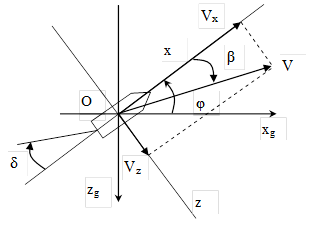

In [ ]:
%matplotlib inline
from IPython.display import Image
Image('model.png', width=500)

Динамика движения может быть описана следующей системой уравнений:

$$
\left[
    \begin{array}{c}
        \dot{\varphi} \\
        \dot{\omega} \\
        \dot{V}
    \end{array}
\right] = 

\left[
    \begin{array}{ccc}
        0 & 1 & 0 \\
        0 & a_{22} & a_{23}/V_0 \\
        0 & a_{32}V_0 & a_{33}
    \end{array}
\right] 
\left[
    \begin{array}{c}
        \varphi \\
        \omega \\
        V
    \end{array}
\right] +

\left[
    \begin{array}{c}
        0 \\
        b_{21} \\
        b_{31}
    \end{array}
\right] \delta
$$

где $\phi$ - курс судна, $\omega$ - угловая скорость судна, $V_z$ - поперечная скорость движения судна, $\delta$ - угол поворота руля судна,
$a_{22}=-3$,  $a_{23}=2$, $a_{32}=0.58$, $a_{33}=-5$, $b_{21}=1$, $b_{31}=18$  -  константы.

Измерению доступен курс судна с погрешностью с нормальным распределением и нулевым математическим ожиданием. Отклонение модели от объекта также описывается нормальным распределением с нулевым математическим ожиданием.

## Задание

1. Задать параметры судна.
2. Задать среднеквадратические отклонения модели (курса, угловой скорости и продольной скорости) и датчика.
3. Построить траекторию движения судна при 4 различных положениях руля.
4. Построить фильтр Калмана для оценки состояния судна.
5. Построить графики изменения, измерения и оценки переменных состояния.
6. Получить формулы для определения глобальных координат судна.
7. Построить траеткорию движения судна, ее измерение и оценку.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

## 1. Зададим параметры судна.



In [16]:
duration = 20 # Время симуляции
dt = 0.1 # Шаг
time = np.arange(0, duration, dt)
V0 = 10 # Начальная скорость
u = np.pi/6
x = np.array([[0],[0],[0]]) # Начальное положение в трех измерениях
"""
Константы
"""
a22 = -3
a23 = 2
a32 = 0.58
a33 = -5
b21 = 1
b31 = 18
"""
Матрицы системы
"""
A = np.array([[0, 1, 0], [0, a22, a23/V0], [0, a32*V0, a33]]) # Матрица, которая представляет динамику системы
B = np.array([[0], [b21], [b31]]) # Матрица входных данных
C = np.array([[1, 0, 0]]) # Матрица выходных данных

A = np.eye(3) + A *dt
B = B * dt

## 2. Зададим среднеквадратические отклонения модели (курса, угловой скорости и продольной скорости) и датчика.



In [ ]:
"""
Среднеквадратические отклонения модели
"""
sigma_phi = 0.1
sigma_w = 0.2
sigma_v = 0.3

"""
Матрица ковариации модели
"""
Ex = np.array(  
    [
        [sigma_phi**2,sigma_phi*sigma_w,sigma_phi*sigma_v ],
        [sigma_w*sigma_phi,sigma_w**2,sigma_w*sigma_v],
        [sigma_v*sigma_phi,sigma_v*sigma_w,sigma_v**2]   
    ]
)
"""
Матрица ковариации измерений
"""
sigma_z = 0.2 # Среднеквадратическое отклонение измерений
Ez = sigma_z**2

## 3. Построим траекторию движения судна при 4 различных положениях руля




In [ ]:
phi = []
w = []
v =[]
z = []
r_angles = [np.pi/6, np.pi/3, np.pi/2, np.pi] # 4 положения руля в радианах
""" 
Случайные шумы
"""
noise_phi = np.random.normal(0,sigma_phi) 
noise_w = np.random.normal(0,sigma_w)
noise_v = np.random.normal(0,sigma_v)
noise_x = np.array([[noise_phi],[noise_w],[noise_v]])

In [ ]:
"""
Генерация случайного шума для каждой итерации и добавление его к вектору
"""
for t in time:
  #u = r_angles[int(t//5)]
  noise_phi = np.random.normal(0,sigma_phi)
  noise_w = np.random.normal(0,sigma_w)
  noise_v = np.random.normal(0,sigma_v)

  noise_x = np.array([[noise_phi],[noise_w],[noise_v]]) 
  x = np.matmul(A,x) + B*u + noise_x # Обновление переменной X
  y = float(np.matmul(C, x))
  z.append(y + np.random.normal(0,sigma_z))

  phi.append(x[0][0])
  w.append(x[1][0])
  v.append(x[2][0])

Text(0.5, 1.0, 'График исходного значения phi')

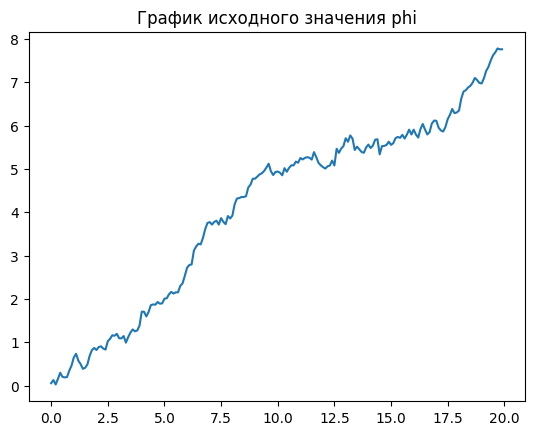

In [ ]:
plt.plot(time,phi)
plt.title("График исходного значения phi")

Text(0.5, 1.0, 'График исходного значения W')

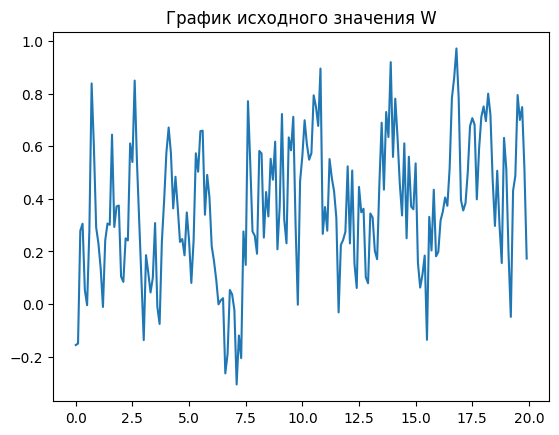

In [ ]:
plt.plot(time,w)
plt.title("График исходного значения W")


Text(0.5, 1.0, 'График исходного значения V')

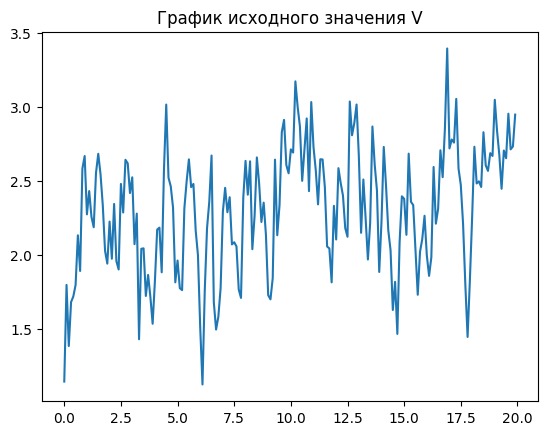

In [ ]:
plt.plot(time,v)
plt.title("График исходного значения V")

## 4. Построим фильтр Калмана для оценки состояния судна



In [ ]:
phi_est = []
w_est = []
v_est = []

Sigma = Ex.copy()
x = np.array([[0],[0],[0]])

for i in range(len(time)):
  #u = r_angles[i]
  x_pred = np.matmul(A,x) + B*u + noise_x # Предсказанное значение вектора состояния системы
  Sigma_pred = np.matmul(np.matmul(A,Sigma),A.T) + Ex # Предсказанная матрица ковариации ошибки вектора состояния системы
  temp = np.matmul(C,Sigma_pred) 
  temp = np.matmul(temp,C.T)
  temp = temp + Ez
  temp = np.linalg.inv(temp)
  temp = np.matmul(C.T,temp)

  K = np.matmul(Sigma_pred,temp) # Коэффициент Калмана

  x = x_pred + K * (z[i] - np.matmul(A,x_pred)) # Обновление значения вектора состояния системы
  phi_est.append(x[0][0])
  w_est.append(x[1][0])
  v_est.append(x[1][0])

  temp = np.eye(3) - np.matmul(K,C)
  Sigma = np.matmul(temp,Sigma_pred)


# 5. Построим графики изменения, измерения и оценки переменных состояния.

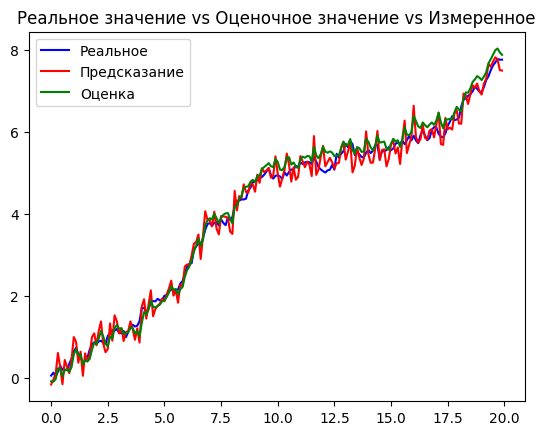

In [12]:
plt.plot(time,phi,c='b')
plt.plot(time,z,c='r')
plt.plot(time,phi_est,c='g')
plt.title("Реальное значение vs Оценочное значение vs Измеренное")
plt.legend(["Реальное", "Предсказание", "Оценка"])
plt.show()

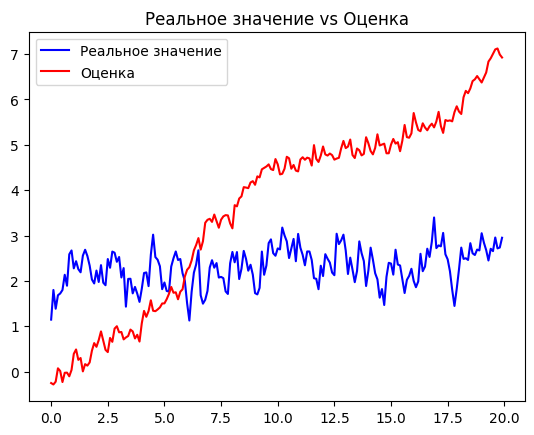

In [13]:
plt.plot(time,v,c='b')
plt.plot(time,v_est,c='r')
plt.title("Реальное значение vs Оценка")
plt.legend(["Реальное значение", "Оценка"])
plt.show()

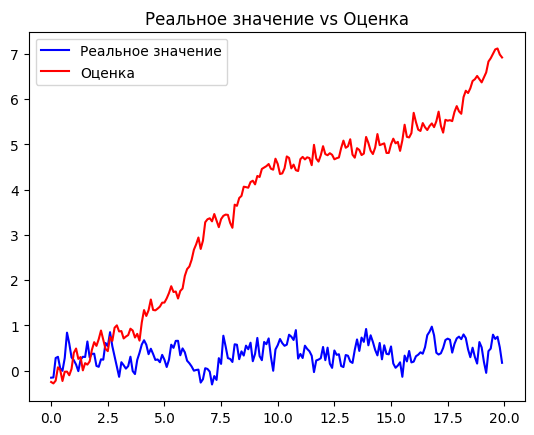

In [14]:
plt.plot(time,w,c='b')
plt.plot(time,w_est,c='r')
plt.title("Реальное значение vs Оценка")
plt.legend(["Реальное значение", "Оценка"])
plt.show()

# 7. Построим траекторию движения судна, ее измерение и оценку



Text(0.5, 1.0, 'Траектория движения судна')

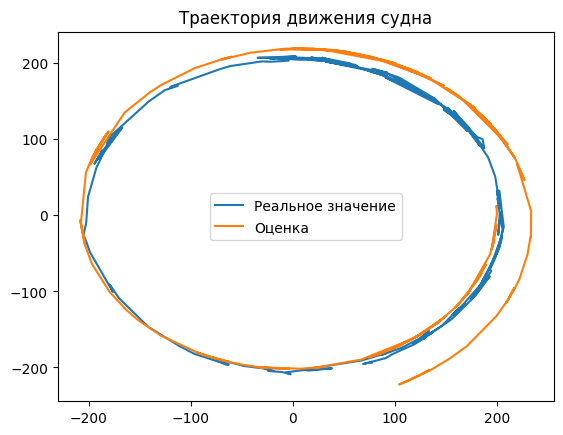

In [15]:
"""
Система в глобальных координатах 
"""
dx = V0*np.cos(phi) + v*np.sin(phi)
dz = v*np.cos(phi) - V0*np.sin(phi)

dx_est = V0*np.cos(phi_est) + v_est*np.sin(phi_est)
dz_est = v_est*np.cos(phi_est) - V0*np.sin(phi_est)
x, z, x_est, z_est = 0,0,0,0
for i in range(len(time)):
    x += dx * dt
    z += dz * dt
    x_est += dx_est * dt
    z_est += dz_est * dt
    
plt.plot(x,z)
plt.plot(x_est, z_est)
plt.legend(["Реальное значение", "Оценка"])
plt.title("Траектория движения судна")

# Выводы: 
1.   Заданы параметры судна.
2.   Заданы среднеквадратические отклонения модели (курса, угловой скорости и продольной скорости) и датчика.
3. Построены траектории движения судна при 4 различных положениях руля.
4. Построен фильтр Калмана для оценки состояния судна.
5. Построены графики изменения, измерения и оценки переменных состояния.
6. Получены формулы для определения глобальных координат судна.
7. Построена траеткория движения судна, ее измерение и оценка.

<!--
 Copyright 2023 Klins
 
 Licensed under the Apache License, Version 2.0 (the "License");
 you may not use this file except in compliance with the License.
 You may obtain a copy of the License at
 
     http://www.apache.org/licenses/LICENSE-2.0
 
 Unless required by applicable law or agreed to in writing, software
 distributed under the License is distributed on an "AS IS" BASIS,
 WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 See the License for the specific language governing permissions and
 limitations under the License.
-->

